# An injection system

We inject a GW150914-like numerical-relativity waveform (SXS:BBH:0305, downloaded from [SXS's Catalog](https://data.black-holes.org/waveforms/index.html)) into LIGO Hanford's designed PSD (from [bilby](https://lscsoft.docs.ligo.org/bilby/)), and then use rational filters to study its ringdown signal.

Here we simply add the signal to noise, instead of going through bilby's functions.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as pl
import qnm_filter
import sys

### Construct the GW strain from numerical relativity

In [3]:
NRwaveform = qnm_filter.SXSWaveforms(filename="SXS:BBH:0305")
NRwaveform.get_remnant_data()

Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json


We focus on $(l=2,m=\pm2)$ harmonics

In [4]:
NRwaveform.import_sxs_data(l=2, m=2, interpolate=True, delta_t=0.05)
NRwaveform.import_sxs_data(l=2, m=-2, interpolate=True, delta_t=0.05)

NRwaveform.pad_data(partition=2, len_pow=1)

Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


All SXS waveforms adopt geometric units with $G=c=M_\odot=1$, and normalize distance and time with BBH's total mass. Below we convert the waveform to SI units.

In [5]:
luminous_intensity = 300 # in Mpc
bbh_mass = 72 # BBH's total mass
NRwaveform.scale_to_si("padded_data", bbh_mass, luminous_intensity)

### Construct detector noise with `bilby`

In [6]:
sampling_frequency = 16384 # in Hz
duration = 8 # in second

Instantiate a `bilby.gw.detector.Interferometer` class.

In [7]:
bilby_ifo = qnm_filter.set_bilby_predefined_ifo('H1', sampling_frequency, duration, start_time=-duration/2)

<Axes: >

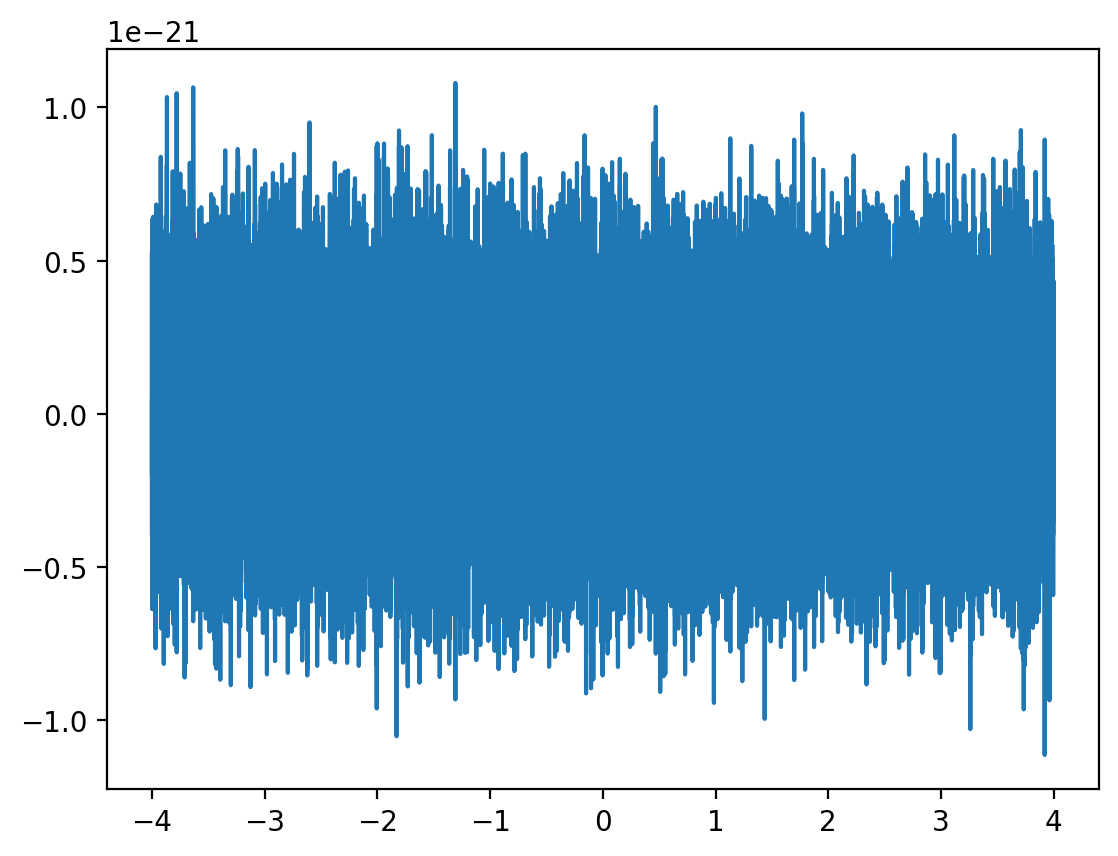

In [8]:
signalH_noise = qnm_filter.bilby_get_strain(bilby_ifo, 0.0)
signalH_noise.plot()

### Inject the GW strain into noise

In [9]:
def get_NR_strain(bilby_ifo, iota, beta, ra, dec, psi):
    """Construct a NR strain
    
    Parameters
    ----------
    bilby_ifo : bilby.gw.detector.Interferometer
        An instance of `bilby.gw.detector.Interferometer`.
    iota : float
        inclination angle in the source frame, in radian.
    beta : float
        azimuth angle in the source frame, in radian.
    ra : float
        right ascension, in radian.
    dec : float
        declination, in radian.
    psi : float
        polarization angle, in radian.
        
    Returns
    -------
    qnm_filter.RealData
        Strain data
    """
    nr_dataset = NRwaveform.harmonics_to_polarizations("data_in_si", iota, beta, [(2,2), (2,-2)])
    hplus = nr_dataset['plus']
    hcross = nr_dataset['cross']
    hplus_interp_func = interp1d(hplus.time, hplus.values, bounds_error=False, fill_value=0)
    hcross_interp_func = interp1d(hcross.time, hcross.values, bounds_error=False, fill_value=0)

    time = bilby_ifo.strain_data.time_array
    hplus = hplus_interp_func(time)
    hcross = hcross_interp_func(time)
    
    fp = bilby_ifo.antenna_response(ra, dec, time[0], psi, 'plus')
    fc = bilby_ifo.antenna_response(ra, dec, time[0], psi, 'cross')

    return qnm_filter.RealData(hplus*fp+hcross*fc, index=time, ifo=bilby_ifo.name)

In [10]:
signalH_no_noise = get_NR_strain(bilby_ifo, 0, 0, 0, 0, 0)
signalH = signalH_noise + signalH_no_noise

(-0.1, 0.1)

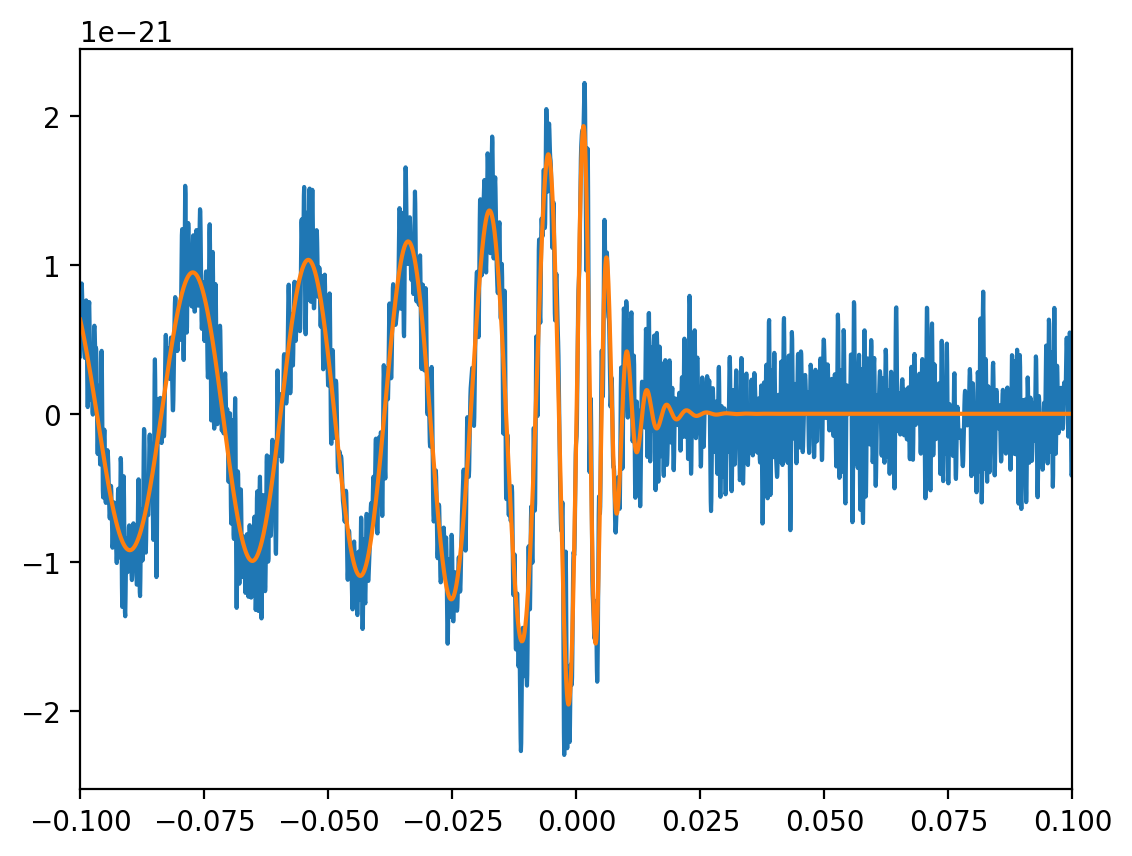

In [11]:
signalH.plot()
signalH_no_noise.plot()
pl.xlim(-0.1,0.1)

### Ringdown analysis with rational filter(s)

In [12]:
fit = qnm_filter.Network(segment_length=0.2, srate=4096, t_init = 0)

In [13]:
fit.original_data['H1'] = signalH
fit.detector_alignment()

In [14]:
fit.pure_noise = {}
fit.pure_noise['H1'] = signalH_noise

In [15]:
fit.pure_nr= {}
fit.pure_nr['H1'] = signalH_no_noise

We use the Welch method to estimate the covariance matrix with pure noise. The estimation with `original_data` may break down when SNR is large enough

In [16]:
fit.condition_data('original_data')
fit.condition_data('pure_noise')
fit.condition_data('pure_nr')
fit.compute_acfs('pure_noise')

In [17]:
fit.cholesky_decomposition()

Sampling remnant mass and spin

In [18]:
delta_mass = 2.0
delta_chi = 0.03
massspace = np.arange(34, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

Interate over the samplings

In [19]:
fit.first_index()
likelihood_data, _ = qnm_filter.parallel_compute(fit, massspace, chispace, 
                                                 num_cpu = -1, model_list = [(2, 2, 0, "p"),
                                                                             (2, 2, 1, "p")])
credible_region = qnm_filter.find_credible_region(likelihood_data)

The posterior quantile of the true mass and spin

In [20]:
qnm_filter.posterior_quantile_2d(likelihood_data, fit, NRwaveform.mf*bbh_mass,
                                 NRwaveform.chif, 
                                 model_list = [(2, 2, 0, "p"), (2, 2, 1, "p")])

0.9999999927010023

Plot 2d contours

Text(0, 0.5, '$\\chi_f$')

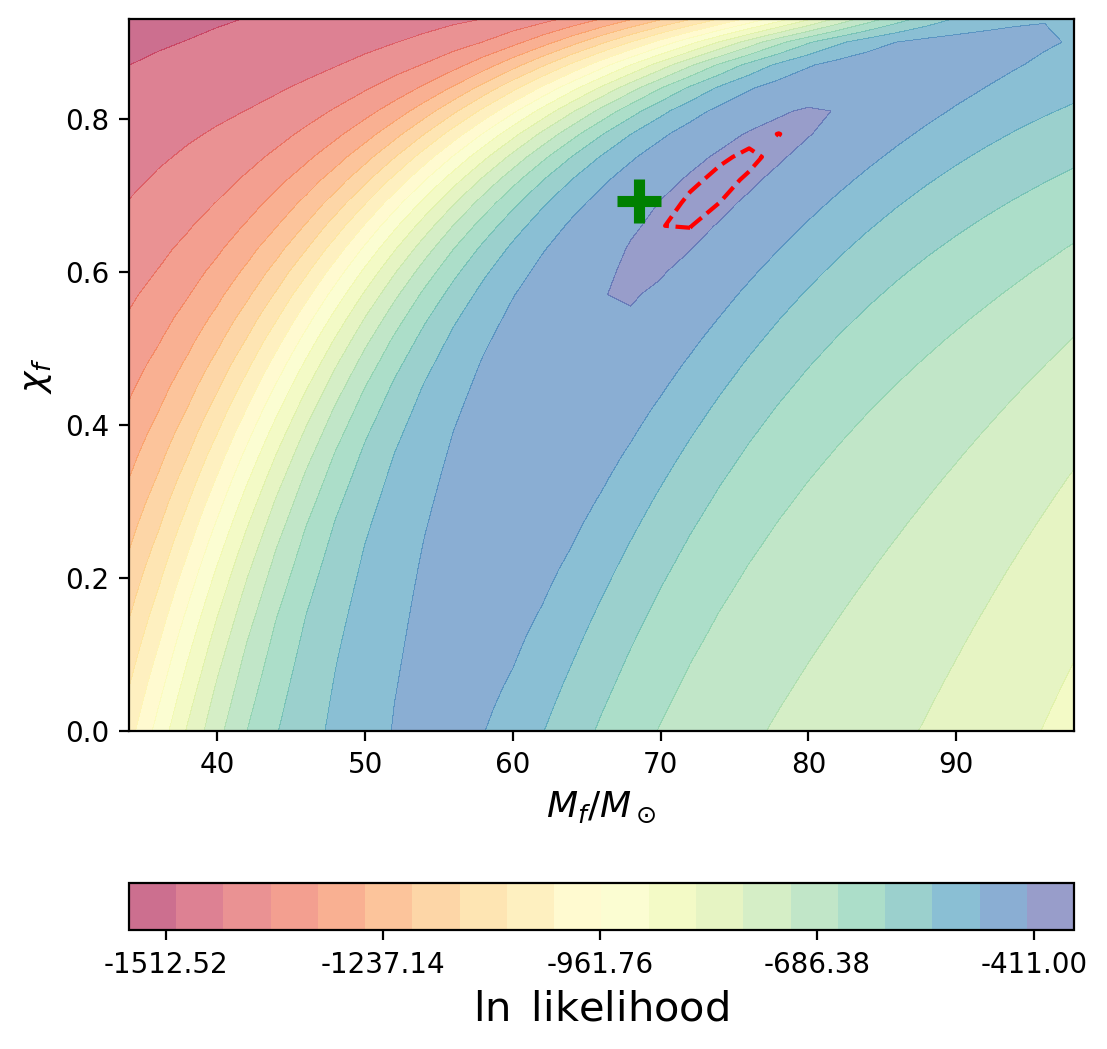

In [21]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=NRwaveform.mf*bbh_mass, y=NRwaveform.chif, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')

Ringdown SNR

In [22]:
fit.compute_SNR(fit.truncate_data(fit.original_data)['H1'], fit.truncate_data(fit.pure_nr)['H1'], 'H1', False)

46.98691583085782